In this problem we will play with stereo matching methods. The problem contains two images ('img1.png', 'img2.png'), and two sets of matched points which was selected manually (cor1.npy and cor2.npy).

## 1. Set up 
First load the images and points, and show them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter, convolve
import scipy

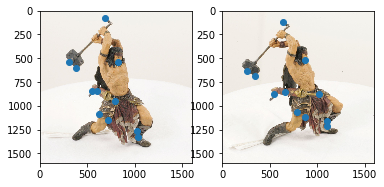

In [2]:
img1 = plt.imread('img1.png')
img2 = plt.imread('img2.png')
cor1 = np.load("cor1.npy")
cor2 = np.load("cor2.npy")

# plot the warriors and selected matching points
plt.subplot(121)
plt.imshow(img1)
plt.scatter(cor1[0], cor1[1])
plt.subplot(122)
plt.imshow(img2)
plt.scatter(cor2[0], cor2[1])

## 2. Compute fundamental matrix using normalized 8-point algorithm

In this question, complete 3 methods: ``compute_fundamental``, ``compute_epipoles``, ``draw_epipolar_lines``. 
1. In ``compute_fundamental``, use 8-point algorithm to compute the fundamental matrix. However, the provided points are larger than 8, so it is an overdetermined linear system. So get a least square solution for the fundamental matrix $F$, and ensure that $rank(F) = 2$ by SVD where the last singular value is set to be zero. See Lecture 14 Page 52,53.
2. In ``compute_norm_fundamental``, perform normalization on image coordinates (that perform better than unnormalized), and compute fundamental matrix using ``compute_fundamental``, and then perform reverse normalization (already complete).
3. In ``compute_epipoles``, compute the epipoles of two images based on the fundamental matrix
4. In ``draw_epipolar_lines``, draw the epipolar lines on the images using the outputs from the above methods. Compare your results with ``epi1.png, epi2.png`` attached.

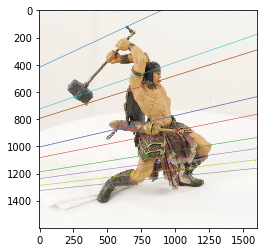

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

def compute_fundamental(x1,x2):
    """ Compute the fundamental matrix from the corresponding points 
        (x1,x2 3*n arrays) using 8 point algorithm.
        Each row in matrix A is constructed as
        [u*u', v*u', u', u*v', v*v', v', u, v, 1] (See Lecture 14 Page 52,53)
        where make sure p1=[u v 1]' and p2=[u' v' 1]'
    """
    
    n = x1.shape[1]
    if x2.shape[1] != n:
        exit(1)
    F = None
    
    ### YOUR CODE BEGINS HERE

    A = np.array([[x1[0][i] * x2[0][i], x1[1][i] * x2[0][i], x2[0][i], x1[0][i] * x2[1][i], x1[1][i] * x2[1][i], x2[1][i], x1[0][i], x1[1][i], 1] for i in range(0, n)]) 
    _, _, A_VT = np.linalg.svd(A)
    F = A_VT.T[:, 8].reshape((3,3))
    
    F_U, F_S, F_VT = np.linalg.svd(F)
    F_S_rank2 = [[F_S[0], 0, 0],[0, F_S[1], 0], [0, 0, 0]]
    F = np.dot(F_U, np.dot(F_S_rank2, F_VT))
    
    ### YOUR CODE ENDS HERE
    
    return F

def compute_norm_fundamental(x1,x2):
    n = x1.shape[1]
    if x2.shape[1] != n:
        exit(1)

    # normalize image coordinates
    x1 = x1 / x1[2]
    mean_1 = np.mean(x1[:2],axis=1)
    S1 = np.sqrt(2) / np.std(x1[:2])
    T1 = np.array([[S1,0,-S1*mean_1[0]],[0,S1,-S1*mean_1[1]],[0,0,1]])
    x1 = np.dot(T1,x1)
    
    x2 = x2 / x2[2]
    mean_2 = np.mean(x2[:2],axis=1)
    S2 = np.sqrt(2) / np.std(x2[:2])
    T2 = np.array([[S2,0,-S2*mean_2[0]],[0,S2,-S2*mean_2[1]],[0,0,1]])
    x2 = np.dot(T2,x2)
    
    # compute F with the normalized coordinates
    F = compute_fundamental(x1,x2)

    # reverse normalization
    F = np.dot(T2.T,np.dot(F,T1))
    
    return F

def compute_epipoles(F):
    """ Compute the epipoles e1, e2 from an input fundamental matrix F
        **Hint: from Fe1=0 and F'e2=0, find the least eigenvector of F or F'
    """
    
    e1 = None
    e2 = None
    ### YOUR CODE BEGINS HERE 
    
    _, _, F_VT = np.linalg.svd(F)
    e1 = F_VT.T[:,2]
    e1 = e1 / e1[2]
    
    _, _, FT_VT = np.linalg.svd(F.T)
    e2 = FT_VT.T[:,2]
    e2 = e2 / e2[2]
    ### YOUR CODE ENDS HERE

    return e1, e2

def draw_epipolar_lines(img1, img2, cor1, cor2):
    """ Draw epipolar lines for given images, corners
        Args:
            img1: image 1
            img2: image 2
            cor1: points in homogeneous image coordinate in img1 (3xn)
            cor2: points in homogeneous image coordinate in img2 (3xn)
    """
    F = compute_norm_fundamental(cor1, cor2)

    e1, e2 = compute_epipoles(F)
    ### YOUR CODE BEGINS HERE
    
    plt.cla()
    for cor in cor1.T:
        gradient = (e1[1] - cor[1]) / (e1[0] - cor[0] + 1e-9)
        b = (e1[1] - gradient * e1[0])
        ymin = b
        ymax = gradient * 2000 + b
        plt.plot([0, 2000], [ymin, ymax], linewidth=0.5)
        #plt.plot([e1[0], cor[0]], [e1[1], cor[1]])
        plt.scatter(cor[0],cor[1], s=3)
        
    plt.imshow(img1)
    plt.savefig('e1.png', dpi=1200)
    
    plt.cla()
    for cor in cor2.T:
        gradient = (e2[1] - cor[1]) / (e2[0] - cor[0] + 1e-9)
        b = (e2[1] - gradient * e2[0])
        ymin = b
        ymax = gradient * 2000 + b
        plt.plot([0, 2000], [ymin, ymax], linewidth=0.5)
       # plt.plot([e2[0], cor[0]], [e2[1], cor[1]])
        plt.scatter(cor[0],cor[1], s=3)
    
    plt.imshow(img2)
    plt.savefig('e2.png', dpi=1200)
    
    ### YOUR CODE ENDS HERE

    return

draw_epipolar_lines(img1, img2, cor1, cor2)